# Air Sea Exchange

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import gsw
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 3
from IPython.display import SVG, display, Image, display_svg, YouTubeVideo

As anyone who has been to sea knows, the interface between ocean and atmosphere can be an incredibly violent place. Within a hurricane, for example, it is in fact impossible to draw a clear boundary between ocean and atmosphere; the extreme winds whip up a continuous emulsion of air and water. Nevertheless, outside of such extreme cases, there exist robust and relatively simple equations for describing the exchange of heat, freshwater, and momentum between atmosphere and ocean.

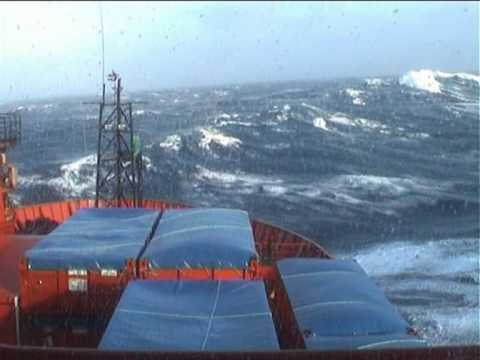

In [2]:
display(YouTubeVideo("BhduxaGtNJ8", width=640, height=480))

### Mixed Layer ###

Our starting point is to consider the ocean surface __mixed layer__ and its coupling with the atmosphere. An important property of the surface ocean is that it nearly always contains a layer of well-mixed (i.e. vertically homogeneous) water overlying the stratified interior (the _thermocline_ / _pycnocline_). This is illustrated in the ARGO profiles shown below.

In [3]:
import intake
cat = intake.open_catalog('nodc.yaml')
argo=cat.nodc.to_dask()
SA = gsw.SA_from_SP(argo.psal, argo.pres, argo.longitude, argo.latitude)
CT = gsw.CT_from_t(SA, argo.temp, argo.pres)
sig0 = gsw.sigma0(SA, CT)

fig, ax = plt.subplots(ncols=3, figsize=(15,8))
ax[0].plot(argo.temp[0], argo.pres[0])
ax[0].plot(CT[0], argo.pres[0])
ax[0].set_xlabel(r'$^\circ$ C')
ax[0].set_title(r'$T$, $\Theta$')

ax[1].plot(argo.psal[0], argo.pres[0])
ax[1].plot(SA[0], argo.pres[0])
ax[1].set_xlabel('g/kg')
ax[1].set_title(r'$S_p$, $S_A$')

ax[2].plot(sig0[0], argo.pres[0])
ax[2].set_xlabel(r'kg m$^{-3}$')
ax[2].set_title(r'$\sigma_0$')

[a.set_ylim([500,0]) for a in ax]
[a.set_ylabel('p (dbar)') for a in ax]

plt.tight_layout()
plt.close()

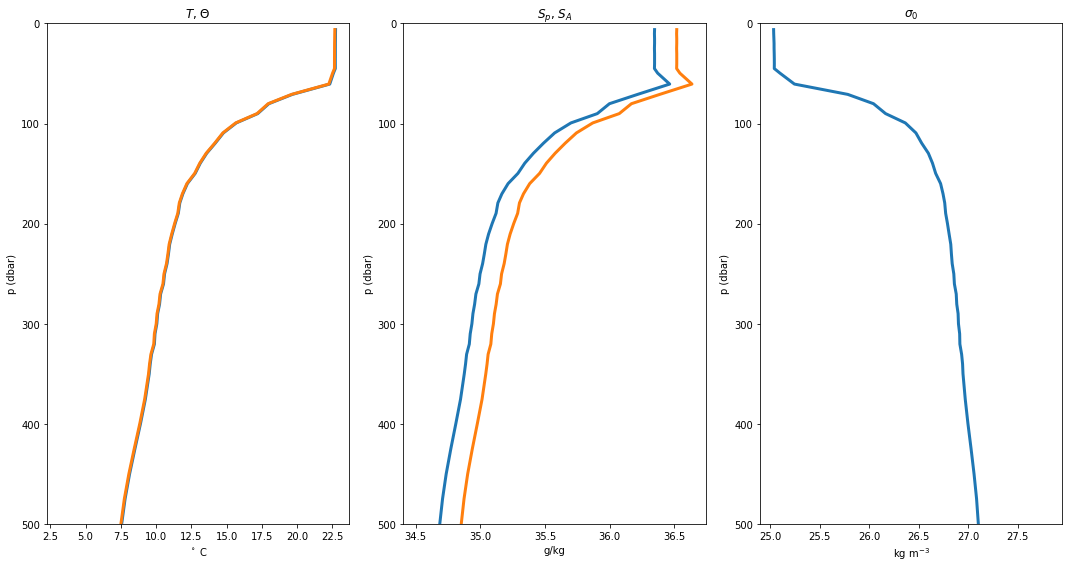

In [4]:
fig

The mixed layer exists primarily because of the winds; the winds generate surface waves which break, and the resulting turbulence homogenizes the properties of the near-surface water.

Generally speaking, the stronger the winds, the deeper the mixed layer. However, buoyancy fluxes can also help determine the mixed layer depth. In winter, strong cooling causes the surface water to become denser than the underlying water. This triggers turbulent convection which deepens the mixed layer.

In [5]:
# Holte and Talley ARGO climatology of mixed layer depth
# http://mixedlayer.ucsd.edu/
# not available over opendap, so we have to download the data
! mkdir -p 04_data
! curl -o 04_data/HolteTalley_MLD.nc http://mixedlayer.ucsd.edu/data/Argo_mixedlayers_monthlyclim_03192017.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0  1663k      0  0:01:01  0:01:01 --:--:-- 1685k


In [6]:
mld = xr.open_dataset('04_data/HolteTalley_MLD.nc')
mld

<xarray.Dataset>
Dimensions:        (iLAT: 180, iLON: 360, iMONTH: 12)
Dimensions without coordinates: iLAT, iLON, iMONTH
Data variables:
    lat            (iLAT) float64 ...
    lon            (iLON) float64 ...
    month          (iMONTH) float64 ...
    mld_da_mean    (iLAT, iLON, iMONTH) float64 ...
    mld_dt_mean    (iLAT, iLON, iMONTH) float64 ...
    mld_da_median  (iLAT, iLON, iMONTH) float64 ...
    mld_dt_median  (iLAT, iLON, iMONTH) float64 ...
    mld_da_std     (iLAT, iLON, iMONTH) float64 ...
    mld_dt_std     (iLAT, iLON, iMONTH) float64 ...
    mld_da_max     (iLAT, iLON, iMONTH) float64 ...
    mld_dt_max     (iLAT, iLON, iMONTH) float64 ...
    mlpd_da        (iLAT, iLON, iMONTH) float64 ...
    mlpd_dt        (iLAT, iLON, iMONTH) float64 ...
    mlt_da         (iLAT, iLON, iMONTH) float64 ...
    mlt_dt         (iLAT, iLON, iMONTH) float64 ...
    mls_da         (iLAT, iLON, iMONTH) float64 ...
    mls_dt         (iLAT, iLON, iMONTH) float64 ...
    num           

In [7]:
# January
fig, ax = plt.subplots()
im = mld.mld_da_max[:,:,0].plot.imshow(extent=[mld.lon[0], mld.lon[-1], mld.lat[-1], mld.lat[0]], yincrease=True)
im.set_clim([0,500])
ax.set_title('January Maximum Mixed Layer Depth')
plt.close()

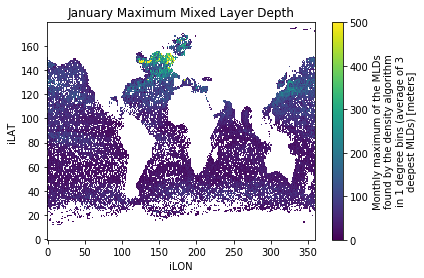

In [8]:
fig

In [9]:
# July
fig, ax = plt.subplots()
im = mld.mld_da_max[:,:,6].plot.imshow(extent=[mld.lon[0], mld.lon[-1], mld.lat[-1], mld.lat[0]], yincrease=True)
im.set_clim([0,500])
ax.set_title('July Maximum Mixed Layer Depth')
plt.close()

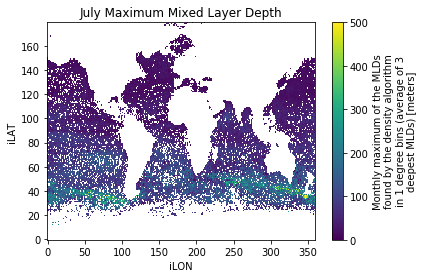

In [10]:
fig

### Simple Model ###

The mixed layer is the part of the ocean that is in direct contact with the atmosphere, and so our equations for air-sea interaction are equations for the evolution of the mixed layer. For the sake of simplicity, we will begin by considering just a one-dimensional model, where all exchange is in the vertical. (In other words, we will not consider lateral exchanges of heat and salt within the mixed layer.) Furthermore, we will assume that the mixed layer is totally isolated from the thermocline and does not exchange heat and salt with the water below. Both these assumptions are unrealistic, but they are a useful starting point.

In this model, the mixed layer thermodynamic state is characterized by three fundamental state variables: $\Theta$ (conservative temperature), $S_A$ (absolute salinity),  and $h$, the mixed layer depth. Through the equation of state, $\Theta$ and $S_A$ determine the mixed layer potential density. (The pressure is irrelevant for now, but in this 1D model, it is simply proportional to depth.) We now describe how air-sea exchange influences the evolution of $\Theta$ and $S_A$.



###  Heat Exchange ###

The heat content of the mixed layer (per unit area) is given by.

$$\mathcal{H} = h \rho c_p^0 \Theta $$

If the mixed layer is isolated from the interior, the first law of thermodynamics can be written as

$$ \frac{d \mathcal{H}}{dt} = Q $$

where $Q$ is the __air-to-sea heat flux__.

### Heat Exchange (approximate) ###

Because density $\rho$ only changes by a about 0.1% during air-sea interaction, it is reasonable to approximate $\rho \simeq \rho_0$. If we further assume that the mixed layer depth $h$ doesn't change, we can write the heat equation as

$$ \frac{d \Theta}{d t} = \frac{Q}{h \rho_0 c_p^0} $$

### Components of the Heat Flux ###

We divide the heat flux $Q$ into four separate components associated with different physical processes.

$$
Q = \underbrace{Q_{sw}}_\text{shortwave radiation} + \underbrace{Q_{lw}}_\text{longwave radiation} + \underbrace{Q_{sh}}_\text{sensible heat flux} + \underbrace{Q_{lh}}_\text{latent heat flux} 
$$

In [14]:
# NOC 1.1a adjusted air sea heat flux
# Grist, J. P. and S. A. Josey, 2003
# Inverse analysis adjustment of the SOC air-sea flux climatology using ocean heat transport constraints.
# J. Climate, 20, 3274-3295, DOI: 10.1175/1520-0442(2003)016%3C3274:IAAOTS%3E2.0.CO;2.
# this is not available over opendap either
! mkdir -p 04_data/noc_1.1a
! cd 04_data/noc_1.1a; curl -O https://www.nodc.noaa.gov/woce/woce_v3/wocedata_1/woceflux/data/SOC/hfls.nc.gz 
! cd 04_data/noc_1.1a; curl -O https://www.nodc.noaa.gov/woce/woce_v3/wocedata_1/woceflux/data/SOC/hfns.nc.gz 
! cd 04_data/noc_1.1a; curl -O https://www.nodc.noaa.gov/woce/woce_v3/wocedata_1/woceflux/data/SOC/hfss.nc.gz
! cd 04_data/noc_1.1a; curl -O https://www.nodc.noaa.gov/woce/woce_v3/wocedata_1/woceflux/data/SOC/rls.nc.gz
! cd 04_data/noc_1.1a; curl -O https://www.nodc.noaa.gov/woce/woce_v3/wocedata_1/woceflux/data/SOC/rss.nc.gz
! gunzip 04_data/noc_1.1a/*.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  723k  100  723k    0     0  1923k      0 --:--:-- --:--:-- --:--:-- 1923k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  772k  100  772k    0     0  2342k      0 --:--:-- --:--:-- --:--:-- 2342k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  553k  100  553k    0     0  1762k      0 --:--:-- --:--:-- --:--:-- 1762k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  562k  100  562k    0     0  2195k      0 --:--:-- --:--:-- --:--:-- 2187k
  % Total    % Received % Xferd  Average Speed   Tim

In [15]:
noca = xr.open_mfdataset('04_data/noc_1.1a/*.nc')
noca

<xarray.Dataset>
Dimensions:    (latitude: 170, longitude: 360, time: 12)
Coordinates:
  * time       (time) object 0002-01-01 00:00:00 ... 0002-12-01 00:00:00
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -84.5 -83.5 -82.5 -81.5 ... 82.5 83.5 84.5
Data variables:
    hfls       (time, latitude, longitude) float32 dask.array<shape=(12, 170, 360), chunksize=(12, 170, 360)>
    hfns       (time, latitude, longitude) float32 dask.array<shape=(12, 170, 360), chunksize=(12, 170, 360)>
    hfss       (time, latitude, longitude) float32 dask.array<shape=(12, 170, 360), chunksize=(12, 170, 360)>
    rls        (time, latitude, longitude) float32 dask.array<shape=(12, 170, 360), chunksize=(12, 170, 360)>
    rss        (time, latitude, longitude) float32 dask.array<shape=(12, 170, 360), chunksize=(12, 170, 360)>
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     Climatological analysis based on ship

## Radiative Fluxes ##

The radiative fluxes in the earth system are often partitioned into a __shortwave__ and __longwave__ component. These names refer to the wavelength of the electromagnetic waves which constitute the radiation. These components occupy very distinct parts of the electromagnetic spectrum. Radiation emitted from the sun is shortwave radiation, while radiation emitted from the earth itself is longwave radiation. The dramatic difference in wavelengths emitted from each body is a result of [Planck's law of blackbody radiation](http://en.wikipedia.org/wiki/Black-body_radiation), which describes how the emission wavelength depends on temperature. Solar radiation has a shorter wavelength than terrestrial because the sun is much hotter than the earth.

In [16]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/7/7c/Atmospheric_Transmission.png")

Atmospheric Transmission. Licensed CC BY-SA 3.0 [Creative Commons Attribution-Share Alike 3.0](http://creativecommons.org/licenses/by-sa/3.0/)

Via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Atmospheric_Transmission.png)

In [17]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/b/bb/"
      "The-NASA-Earth%27s-Energy-Budget-Poster-Radiant-Energy-System-satellite-infrared-radiation-fluxes.jpg")

By [NASA](http://science-edu.larc.nasa.gov/energy_budget/), Public domain. Via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File%3AThe-NASA-Earth's-Energy-Budget-Poster-Radiant-Energy-System-satellite-infrared-radiation-fluxes.jpg)

### Shortwave Radiation ##

The average value of incoming solar radiation at the top of Earth's atmosphere is 342 W m$^{-2}$, although this value varies considerably with latitude and season. Some of the solar radiation is absorbed by the atmosphere or reflected back to space by clouds and aerosols, never reaching the ocean. Furthermore, the ocean doesn't absorb all of the shortwave radiation that reaches its surface; some is also reflected back to space. The __albedo__ $\alpha$ describes how much radiation is absorbed versus reflected. Therefore, the shortwave heating is given by

$$ Q_{sw} = (1 - \alpha)Q^{inc}_{sw} $$

where $Q^{inc}_{sw}$ is the incident shortwave radiation.

### Albedo ##

An albedo of 0 means that all of the incident radiation is absorbed. The ocean's average albedo is about 0.06, although it does vary somewhat depending on sea state (i.e. depending on what the surface wave field is like). The relatively low albedo of the ocean means that the ocean is a very effective absorber of radiation, especially compared to ice. The strong change in albedo that occurs when the high-latitude ocean freezes or melts is therefore a significant climate feedback.

In [18]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/e/e2/Ceres_2004_clear_sky_albedo.png', width=800)

By Giorgiogp2 (Own work). License [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0) or [GFDL](http://www.gnu.org/copyleft/fdl.html), via [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Ceres_2004_clear_sky_albedo.png)


In [23]:
Qlims = (-250,250)
fig, ax = plt.subplots()
im = noca.rss[11].plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('December Shortwave Radiation (W m$^{-2}$)')
plt.close()

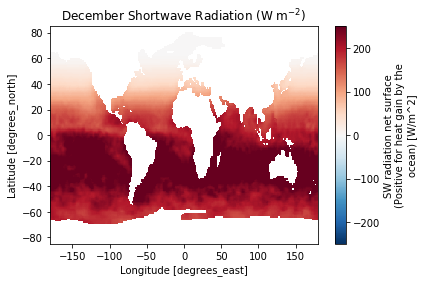

In [24]:
fig

In [25]:
fig, ax = plt.subplots()
im = noca.rss[5].plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('June Shortwave Radiation (W m$^{-2}$)')
plt.close()

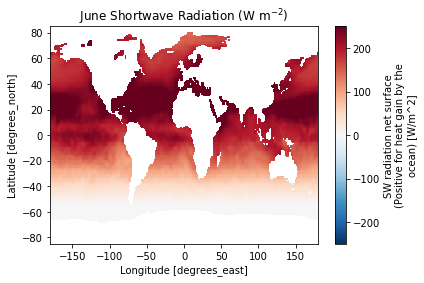

In [26]:
fig

In [27]:
fig, ax = plt.subplots()
im = noca.rss.mean(dim='time').plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('Annual Mean Shortwave Radiation (W m$^{-2}$)')
plt.close()

/Users/csjones/anaconda3/envs/phys_ocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


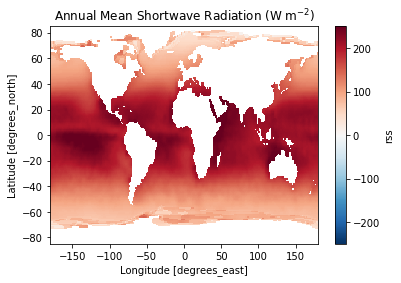

In [28]:
fig

In [29]:
sw_zm = noca.rss.fillna(0).mean(dim=('time', 'longitude'))

fig, ax = plt.subplots()
sw_zm.plot()
plt.title('Annual Zonal Mean Shortwave Radiation (W m$^{-2}$)')
plt.grid()
plt.close()

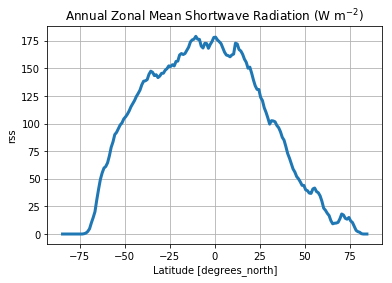

In [30]:
fig

### Longwave Radiation ###

Because of its much lower temperature, the earth emits radiation in the longwave (i.e. infrared) band. On a global scale, emission is the main way the planet balances the incoming solar radiation to maintain its thermal equilibrium. The power of emitted radiation is strongly dependent on temperature; specifically, the Stefan-Boltzman law states that


$$ Q_{lw}^{emitted} = - \sigma T^4 $$

where $\sigma = 5.67 \times 10^-8$ W m$^{-2}$ K$^{-4}$ is the Stefan-Boltzman constant. (It is important to remember to use absolute temperature in deg. Kelvin when evaluating this formula.) Here we have chosen to maintain the same sign convention for longwave radiation as for shortwave. 


$Q_{lw}^{emitted}$ is not the only contribution to the longwave flux. The atmosphere also emits longwave radiation itself, and some of this radiation is absorbed by the ocean. There is a large amount of cancellation between these two components, but in the net
The fact that $Q_{lw}$ is negative definite means that longwave emissions acts to cool the ocean.

Longwave cooling is indeed a significant sink of heat from the ocean. The mean value of the longwave cooling is around -50 W m$^{-2}$.

In [31]:
fig, ax = plt.subplots()
im = noca.rls.mean(dim='time').plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('Annual Mean Longwave Radiation (W m$^{-2}$)')
plt.close()

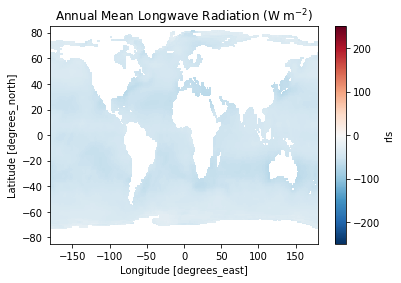

In [32]:
fig

In [35]:
lw_zm = noca.rls.fillna(0).mean(dim=('time', 'longitude'))

fig, ax = plt.subplots()
sw_zm.plot(label='shortwave')
lw_zm.plot(label='longwave')
plt.title('Annual Zonal Mean Fluxes (W m$^{-2}$)')
ax.legend()
plt.grid()
plt.close()


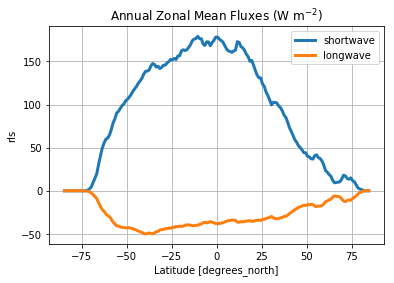

In [36]:
fig

### Sensible Heat Flux ###

Radiative fluxes transmit heat energy over long distances, e.g.~from the sun to the earth. Sensible heat exchange instead depends on direct molecular contact between air and water. The molecules of the two fluids bump against each other, thereby exchanging heat energy. When the ocean and air temperature are the same, the sensible heat flux is therefore zero. When they differ, heat is exchanged in such as way as to homogenize the temperature. This is analogous to the phenomenon of "Newtonian cooling'' commonly studied in introductory physics courses.

### Turbulent Exchange  ###

The rate of exchange is highly dependent on the sea state, and in particular on the winds, which generate breaking waves and turbulence. It is easy to imagine how breaking waves enhance the exchange of heat: they literally pull air down into the water (bubbles) and splash water up into the air (sea spray). It is much harder to quantify this process mathematically. Nevertheless, laboratory experiments and field campaigns have permitted us to develop empirical formulas to do so.

### Bulk Formula ###

The commonly accepted formula for sensible heat flux is

$$
Q_s = \rho^{air} c_p^{air} C_H | \Delta \mathbf{u} | (T_{10} - T) \ .
$$

The subscript $_{10}$ refers to the properties of air at 10 m altitude ($T_{10}$ is air temperature at 10 m). Although this height is somewhat arbitrary, it is a widely-used convention. $\Delta \mathbf{u} = \mathbf{u}_{10} - \mathbf{u}$ refers to the difference between the wind speed at 10 m and the ocean current speed. $c_p^{air} = 1030$ J kg$^{-1}$ K$^{-1}$ is the specific heat of air and $\rho^{air}$ is the density of air (approximately $1.3$ kg m$^{-3}$). Note it is the in-situ temperature $T$, _not conservative temperature_, which appears in the bulk formula.

### Drag Coefficient ###

All of the complexity and difficulty of turbulent air-sea exchange is absorbed into the parameter $C_H$, the turbulent __transfer coefficient__ for sensible heat exchange. This non-dimensional coefficient is $O(1000)$ but is a strongly nonlinear function of $|\Delta \mathbf{u}|$. It also depends on the stability of the stratification within the atmospheric boundary layer. The figure below illustrates this dependence.

In [37]:
Image(url='04_images/LY09_Drag_Coefficient.png')

Turbulent transfer coefficients as a function of wind speed, taken from Large and Yeager (2009). Note that $C_H$ is different in stable, ($C_{H_s}$) and unstable ($C_{H_u}$) atmospheric stratification.

For strong winds, $C_H$ is a positive function of $|\Delta \mathbf{u}|$. But as $ | \Delta \mathbf{u} | $ approaches zero, $C_H$ actually increases very rapidly. This means that the heat exchange doesn't necessarily vanish for very weak winds, as one might mistakenly conclude from the figure. Further refining our description of $C_H$, especially for extremely strong winds (i.e.~within hurricanes) is an ongoing topic of study for air-sea-interaction researchers.

In [39]:
Qlims = (-50,50)
fig, ax = plt.subplots()
im = noca.hfss[11].plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('December Sensible Heat Flux (W m$^{-2}$)')
plt.close()

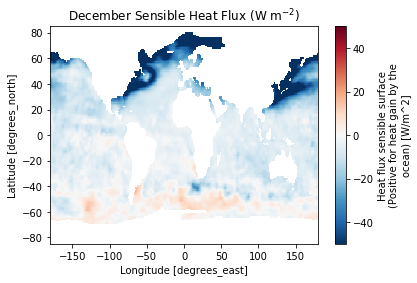

In [40]:
fig

In [41]:
fig, ax = plt.subplots()
im = noca.hfss[5].plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('June Sensible Heat Flux (W m$^{-2}$)')
plt.close()

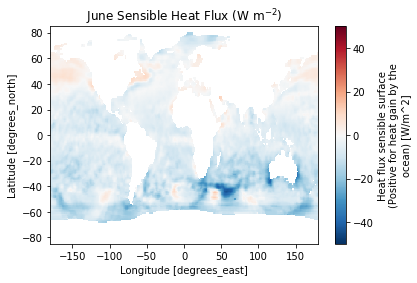

In [42]:
fig

In [43]:
fig, ax = plt.subplots()
im = noca.hfss.mean(dim='time').plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('Annual Mean Sensible Heat Flux (W m$^{-2}$)')
plt.close()

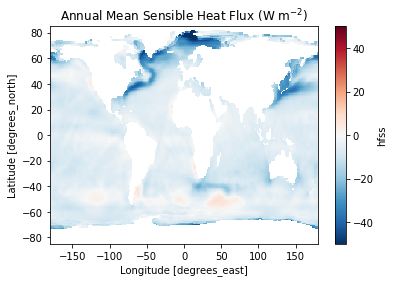

In [44]:
fig

The annual mean contribution of $Q_s$ to $Q$ is almost negligible. This is because, on average, the $T$ and $T_{10}$ are very close. There is, however, a strong seasonal cycle in sensible heat exchange. Because of the large ocean heat capacity, the ocean is usually colder than the air in summer and warmer than the air in the winter. This drives important seasonal changes in circulation.

### Latent Heat Flux ###



The latent heat flux is produced when seawater evaporates to become atmospheric water vapor. This process requires thermodynamic energy and therefore extracts heat from the ocean. The latent heat flux is given by

$$ Q_{lh} = -L_e E $$

where $E$ is the evaporation rate (in kg m$^{-2}$ s$^{-1}$), and $L_e \simeq 2.5 \times 10^6$ J kg$^{-1}$ is the latent heat of vaporization. The fact that $Q_{lh}$ is negative is due to our sign convention: the latent heat flux always cools the ocean

### Evaporation Rate ###

What sets the evaporation rate $E$? As with sensible heat, evaporation is a turbulent exchange which depends on direct molecular contact between air and water. It is given by another bulk formula:

$$ E = - \rho^{air} c_E | \Delta \mathbf{u} | (q_{10} - q_{sat}) $$

where $q_{10}$ and $q_{sat}$ refer, respectively, to the specific humidity of the air at 10 m and the saturation specific humidity right at the sea surface, and $c_E$ is the exchange coefficient for water vapor. Specific humidity measures the mass fraction of water vapor in air. It is a non-dimensional unit but is frequently reported as g kg$^{-1}$ (grams of water per kilogram of air).



### Saturation Specific Humidty ###

The maximum amount of water vapor that it can hold is called the __saturation specific humidity__. This quantity is an exponential function of the air temperature. The relationship between $q_{sat}$ and temperature is given by the __Clausius-Clapeyron relation__. A practical formula for evaluating the Clausius-Clapeyron relation over the ocean is

$$
q_{sat}(T) = 0.98 \frac{6.4 \times 10^5 \mbox{ kg m}^{-3}}{\rho^{air}} e^{-(5107.4 K) / T} \ .
$$

Right at the sea-surface, the air is always at the same temperature as the ocean ($T$) and is always completely saturated; that's why $q_{sat}$ is a function of SST. But at 10 m altitude, the air can have a different specific humidity due to atmospheric circulation. If the two values of $q$ are not equal, the ocean will evaporate at rate $E$.


In [45]:
Qlims = (-250,250)
fig, ax = plt.subplots()
im = noca.hfls.mean(dim='time').plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('Annual Mean Latent Heat Flux (W m$^{-2}$)')
plt.close()

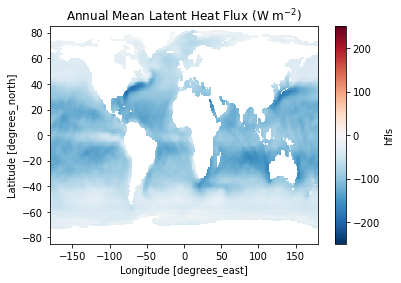

In [46]:
fig

$Q_{lh}$ is the dominant mechanism for cooling the ocean, with an global, annual mean value of close to 100 W m$^{-2}$. $Q_{lh}$ is strongest where strong, dry continental winds blow over the oceans, as occurs near the western boundaries of the midlatitude basins (e.g. over the Gulf Stream).


In [47]:
sh_zm = noca.hfss11a.fillna(0).mean(dim=('time', 'longitude'))
lh_zm = noca.hfls11a.fillna(0).mean(dim=('time', 'longitude'))
nethf_zm = noca.hfns11a.fillna(0).mean(dim=('time', 'longitude'))

fig, ax = plt.subplots()
sw_zm.plot(label='shortwave')
lw_zm.plot(label='longwave')
sh_zm.plot(label='sensible')
lh_zm.plot(label='latent')
nethf_zm.plot(label='net', color='k')


plt.title('Annual Zonal Mean Fluxes (W m$^{-2}$)')
ax.legend()
plt.grid()
plt.close()


AttributeError: 'Dataset' object has no attribute 'hfss11a'

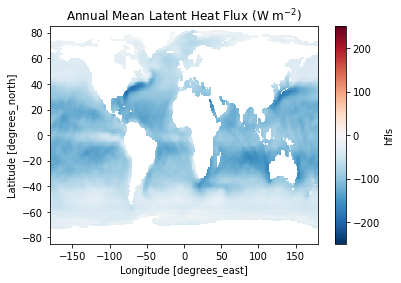

In [48]:
fig

In [49]:
Qlims = (-200,200)
fig, ax = plt.subplots()
im = noca.hfns.mean(dim='time').plot(yincrease=True, cmap='RdBu_r')
im.set_clim(Qlims)
plt.title('Annual Mean Net Heat Flux (W m$^{-2}$)')
plt.close()

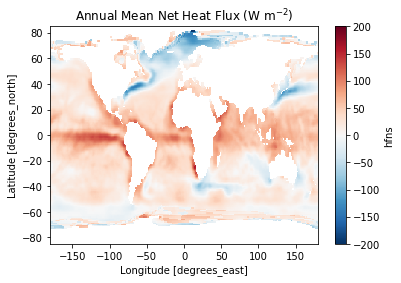

In [50]:
fig

## Freshwater Fluxes ##

In [51]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/"
      'Diagram_of_the_Water_Cycle.jpg/1024px-Diagram_of_the_Water_Cycle.jpg')

By Ehud Tal (Own work) [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons
https://commons.wikimedia.org/wiki/File%3ADiagram_of_the_Water_Cycle.jpg


In [52]:
cat = intake.open_catalog('ep.yaml')
evap=cat.evap.to_dask()
precip=cat.precip.to_dask()
print(evap.load())
print(precip.load())

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    evapr    (lat, lon) float64 nan nan nan nan ... -0.1009 -0.1009 -0.1009
Attributes:
    NCO:                       4.3.7
    nco_openmp_thread_number:  1
    history:                   Tue Jul 21 15:45:00 2015: ncatted -a gridtype,...
    Conventions:               IRIDL
<xarray.Dataset>
Dimensions:  (X: 144, Y: 72)
Coordinates:
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
Data variables:
    prcp     (Y, X) float64 0.4733 0.4781 0.4642 0.4749 ... 0.309 0.3263 0.3332
Attributes:
    Conventions:  IRIDL


In [53]:
precip_i = -360/10*precip.prcp.rename({'X': 'lon', 'Y': 'lat'}).interp_like(evap)
e_minus_p = precip_i + evap.evapr
e_minus_p

<xarray.DataArray (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, -17.111193, -17.182183, ..., -17.152978, -17.064621,
               nan],
       [       nan, -17.234316, -17.315423, ..., -17.042715, -16.960526,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [54]:
fig, ax = plt.subplots()
im = evap.evapr.plot(yincrease=True, cmap='PiYG_r')
im.set_clim([-300,300])
plt.title('Annual Mean Evaporation (cm/year)')
plt.close()

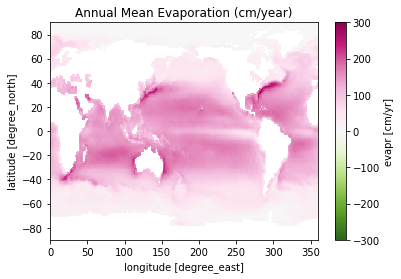

In [55]:
fig

In [56]:
fig, ax = plt.subplots()
im = precip_i.plot(yincrease=True, cmap='PiYG_r')
im.set_clim([-300,300])
plt.title('Annual Mean Precipitation (cm/year)')
plt.close()

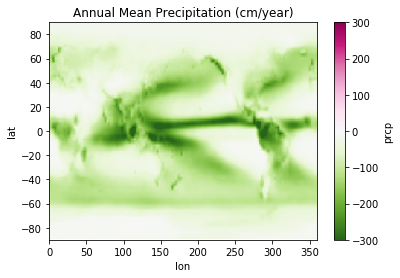

In [57]:
fig

In [58]:
e_minus_p

<xarray.DataArray (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan, -17.111193, -17.182183, ..., -17.152978, -17.064621,
               nan],
       [       nan, -17.234316, -17.315423, ..., -17.042715, -16.960526,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [59]:
fig, ax = plt.subplots()
im = e_minus_p.plot(yincrease=True, cmap='PiYG_r')
im.set_clim([-200,200])
plt.title('Annual Mean Evaporation minus Precipitation (cm/year)')
plt.close()

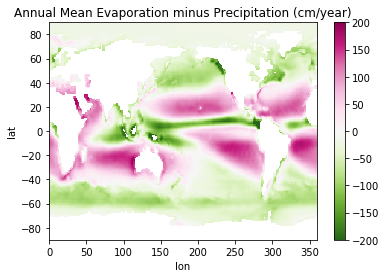

In [60]:
fig

### Freshwater and Salinity ###

The salt stays in the ocean, while freshwater comes in and out through __evaporation__, __precipitation__, and __runoff__ ($E-P-R$). This changes the total mass (and volume) of the ocean ever so slightly.

How does $E-P-R$ affect the ocean salinity? Increasing freshwater dilutes the salinity, and evaporation concentrates it.

### Conservation of Mass / Volume 

The mass of the water column is given by

$$
\int_{-H}^\eta \rho dz
$$

The rate of change of mass is proportional to $E-P-R$. 

$$
\frac{d}{dt} \int_{-H}^\eta \rho dz \propto -(E - P - R)
$$

To simplify things somewhat, here we will treat seawater density as constant, i.e. $\rho = \rho_0$, allowing us to convert the mass rate of change to volume rate of change

$$
\frac{d}{dt} \int_{-H}^\eta dz = \frac{d \eta}{dt} = - \frac{E - P - R}{\rho_{fw}}
$$

where $\rho_{fw}$ is the density of freshwater.

### Conservation of Salt

The total salt mass in the water column is:

$$
\int_{-H}^\eta \rho S dz
$$

Again, approximating density as constant, this simplifies to:

$$
\rho_0 \int_{-H}^\eta S dz
$$

Neglecting lateral transports (which move salt around but can't remove it from the ocean), salt conservation states that

$$
\frac{d}{dt} \int_{-H}^\eta S dz = 0
$$


### Virtual Salt Flux

Applying Leibniz' rule to the salt conservation equation, we obtain

$$
\int_{-H}^\eta \frac{dS}{dt} dz = - S(\eta) \frac{d \eta}{dt} = S(\eta) \frac{E - P - R}{\rho_{fw}}
$$

This tells us that the average salinity of the water column increases at a rate proportional to $E - P - R$. The quantity on the right is often called the _virtual salt flux_ because it plays a similar role to the heat flux. If this flux is felt over the mixed layer, the rate of change of mixed layer salinity is given by

$$
\frac{d S}{d t} = \frac{S(E - P - R)}{h \rho_{fw}} .
$$